In [1]:
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

## Dataset generation

In [2]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

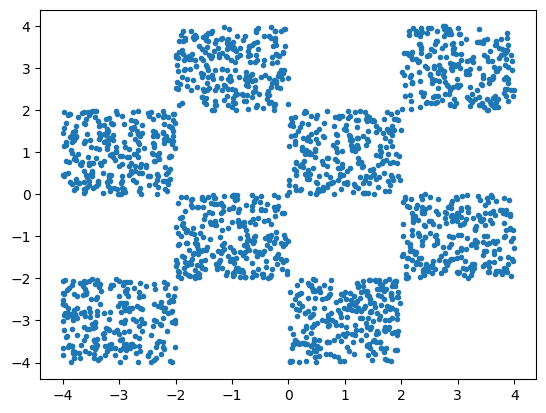

In [3]:
X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

## Define MLP score function

Here, we use the `flax` [library](https://flax.readthedocs.io/en/latest/) to define a fully connected neural network that represents our score function.

In [4]:
Activation = Callable[[jax.Array], jax.Array]

class MLP(nn.Module):
    
    features: Sequence[int]
    activation: Activation = nn.swish

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x

model = MLP(features=[64, 64, 2])
print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,2]  │ float32[1,2]  │                        │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: float32[2,64]  │
│         │        │               │               │                        │
│         │        │               │               │ 192 (768 B)            │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: fl

## Define the score matching loss

In [5]:
def score_matching_loss(params: chex.ArrayTree, batch: jax.Array) -> float:
    # SM loss: |f(x)|^2 + 2 div f(x)
    loss = 0.0

    # First |f(x)|^2 term
    fs = model.apply(params, batch)
    loss += jnp.sum(jnp.square(fs))

    # Second 2 div f(x) term
    def unbatched_f(x):
        return jnp.squeeze(model.apply(params, x[None, ...]), axis=0)
    divs = jax.vmap(lambda x: jnp.trace(jax.jacobian(unbatched_f)(x)))(batch)
    loss += 2 * jnp.sum(divs)

    return loss

## Train the model

In [6]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))


@jax.jit
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree, 
    opt_state: optax.OptState,
) -> tuple[float, chex.ArrayTree, optax.OptState]:
    loss, grad = jax.value_and_grad(score_matching_loss)(params, batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [7]:
params = model.init(next(prng_seq), X_train[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(data=X_train, batch_size=128, key=next(prng_seq))

losses = []
for _ in tqdm.tqdm(range(5000)):
    batch = next(bm)
    loss, params, opt_state = do_batch_update(batch, params, opt_state)
    losses.append(loss)
losses = np.array(losses)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1904.25it/s]


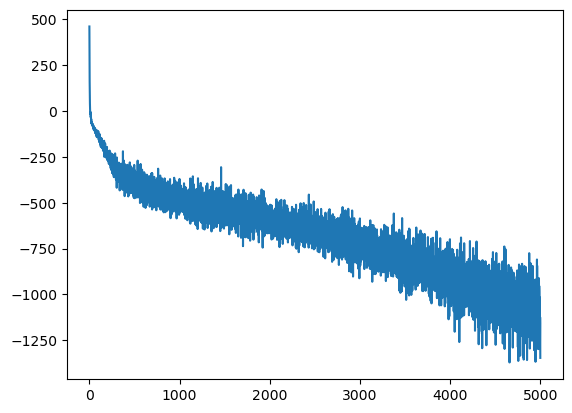

In [8]:
plt.plot(losses)

## Sample from the model

In [9]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

(-4.0, 4.0)

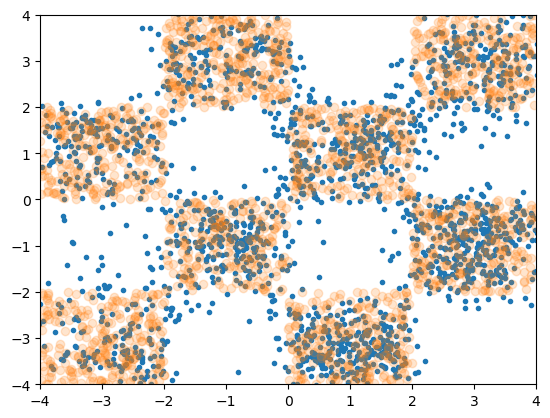

In [10]:
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(2000, 2)),
    1000)
plt.plot(samples[:, 0], samples[:, 1], '.')
plt.plot(X_train[:, 0], X_train[:, 1], 'o', alpha=0.2)

plt.xlim([-4, 4])
plt.ylim([-4, 4])